In [0]:
from sklearn import svm, datasets 
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix, fbeta_score, make_scorer, average_precision_score, auc



import pylab as plt
import numpy as np
from scipy.stats import randint as sp_randint , uniform
import pandas as pd

from sklearn.metrics import precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
from inspect import signature

# Dataset:  two unbalcanced clusters difficult to separate 

In [0]:
random_state=0

# two clusters of random points with unbalanced classes
class_ratio=0.05

n_samples_1 = 2000
n_samples_2 = int(class_ratio*n_samples_1)

centers = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [1.5, 0.5]
X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state=0, shuffle=False)

X_train, X_test, y_train, y_test = train_test_split(X , y ,test_size=.5,
                                                    random_state=random_state)

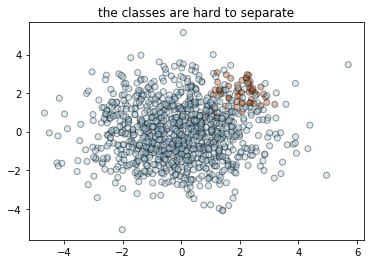

In [3]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors='k',alpha=0.4);
plt.title('the classes are hard to separate');


In [0]:
def add_metrics(y_test,y_score,y_pred,model,df=None):
  # records the scores in a DataFrame
  
  average_precision = average_precision_score(y_test, y_score)

  cm=confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp =cm.ravel()

  df2=pd.DataFrame([[model,tn, fp, fn, tp,average_precision,y_score,y_pred]],columns=['model','tn', 'fp', 'fn', 'tp','AP','y_score','y_pred'])
  if df is None:
    df=df2
  else:
    df=pd.concat((df,df2),ignore_index=True)
  return(df)
  

In [0]:
def cm_score(y_test,y_pred,c_fn,c_fp):
  
  cm=confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp =cm.ravel()
  score=-c_fn*fn - c_fp*fp
  return(score)

scoring = make_scorer(cm_score, c_fn=100, c_fp=2, greater_is_better=True)

In [0]:
def plot_pr_mat(y_test,df):
  
  for n in df.index:
  
    y_score=df.loc[n,'y_score']
    name=df.loc[n,'model']
    
  
    average_precision = average_precision_score(y_test, y_score)
    precision, recall, _ = precision_recall_curve(y_test, y_score)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision,  alpha=0.5,
             where='post', label ='{0:}  AP={1:0.2f}'.format(name,average_precision))
    # plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve')
    plt.legend()

In [0]:
def plot_roc_mat(y_test,df):

  for n in df.index:
  
    y_score=df.loc[n,'y_score']
    name=df.loc[n,'model'] 
    
    fpr, tpr, thresholds = roc_curve(y_test,  y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=1, label='%s (AUC = %0.2f)' % (name,roc_auc));





  plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
           label='Chance', alpha=.8)
  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC viewed')
  plt.legend(loc="lower right");
  plt.axis('square');

In [0]:
# scoring='average_precision'
# scoring='balanced_accuracy'
# scoring='f1_weighted'
scoring='roc_auc'

## Radial basis function SVC

In [7]:
wclf = svm.SVC(C=1,kernel='rbf' ,random_state=0, class_weight="balanced",gamma="scale")

param_dist = {
             # "class_weight": {1, uniform(1,20)} ,
              "C": uniform(0.01,100),
            }

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(wclf, scoring=scoring, param_distributions=param_dist,  cv=5, iid=False)

random_search.fit(X_train, y_train)

sorted(random_search.cv_results_.keys())
display(random_search.cv_results_['mean_test_score'])
wclf=random_search.best_estimator_

y_score = wclf.decision_function(X_test)
y_pred = wclf.predict(X_test)


df=add_metrics(y_test,y_score,y_pred,'wrSVC',df=None)


array([0.96945994, 0.98124262, 0.97057912, 0.98114262, 0.97844874,
       0.96808721, 0.9740185 , 0.97916185, 0.98189868, 0.96945034])

In [8]:
df

,model,tn,fp,fn,tp,AP,y_score,y_pred
0,wrSVC,927,75,1,47,0.65996,"[1.0819155617421168, -3.4110545004127615, -3.0...","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Linear SVC

In [9]:
lclf = svm.SVC(C=1,kernel='linear' ,random_state=0, class_weight="balanced",gamma="scale")

param_dist = {
             # "class_weight": {1, uniform(1,20)} ,
              "C": uniform(0.01,100),
            }

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(lclf, scoring=scoring, param_distributions=param_dist,  cv=5, iid=False)

random_search.fit(X_train, y_train)

sorted(random_search.cv_results_.keys())
display(random_search.cv_results_['mean_test_score'])
lclf=random_search.best_estimator_

y_score = lclf.decision_function(X_test)
y_pred = lclf.predict(X_test)


df=add_metrics(y_test,y_score,y_pred,'lSVC',df)


array([0.96563618, 0.96563618, 0.96563618, 0.96563618, 0.96563618,
       0.96563618, 0.96563618, 0.96563618, 0.96563618, 0.96563618])

## Decision Tree

In [10]:
param_dist = {
              "max_depth": [3, None],
              "max_features": sp_randint(1, X_train.shape[1]),
              "min_samples_split": sp_randint(2, 20),
            }

# run randomized search
n_iter_search = 20
tclf = DecisionTreeClassifier(  criterion="entropy",class_weight="balanced")
#clf = DecisionTreeClassifier(  criterion="entropy",class_weight={0:1,1:10})
random_search = RandomizedSearchCV(tclf, scoring=scoring, param_distributions=param_dist,  cv=5, iid=False)

random_search.fit(X_train, y_train)

sorted(random_search.cv_results_.keys())
display(random_search.cv_results_['mean_test_score'])
tclf=random_search.best_estimator_

y_score = tclf.predict_proba(X_test)[:,1]
y_pred = tclf.predict(X_test)


df=add_metrics(y_test,y_score,y_pred,'DT',df)

array([0.94393011, 0.92714941, 0.94287531, 0.83358269, 0.92531042,
       0.90991868, 0.88652901, 0.93385313, 0.80109461, 0.83781656])

## RandomForest

In [11]:
param_dist = {
              "n_estimators": sp_randint(1, 40),
              "max_depth": [3, None],
              "max_features": sp_randint(1, 2),
              #"max_features": uniform(0.1, 1.),
              #"max_features": ["auto","log2"],
              "min_samples_split": sp_randint(2, 20),
            }

# run randomized search
n_iter_search = 20
rfclf = RandomForestClassifier( bootstrap=20, criterion="entropy",class_weight="balanced")
random_search = RandomizedSearchCV(rfclf, scoring=scoring, param_distributions=param_dist,  cv=5, iid=False)

random_search.fit(X_train, y_train)

sorted(random_search.cv_results_.keys())
display(random_search.cv_results_['mean_test_score'])
rfclf=random_search.best_estimator_

y_score = rfclf.predict_proba(X_test)[:,1]
y_pred = rfclf.predict(X_test)


df=add_metrics(y_test,y_score,y_pred,'RF',df)

array([0.96615349, 0.95080882, 0.95817296, 0.96121409, 0.9496669 ,
       0.96044621, 0.92407348, 0.94464703, 0.96641868, 0.96451416])

In [12]:
#roc_auc
df.iloc[:,0:-2]

,model,tn,fp,fn,tp,AP
0,wrSVC,927,75,1,47,0.659960
1,lSVC,885,117,1,47,0.422870
2,DT,928,74,1,47,0.520927
3,RF,957,45,3,45,0.580367


In [13]:
#f1_weighted
df.iloc[:,0:-2]

,model,tn,fp,fn,tp,AP
0,wrSVC,927,75,1,47,0.659960
1,lSVC,885,117,1,47,0.422870
2,DT,928,74,1,47,0.520927
3,RF,957,45,3,45,0.580367


In [14]:
#balanced accuracy
df.iloc[:,0:-2]

,model,tn,fp,fn,tp,AP
0,wrSVC,927,75,1,47,0.659960
1,lSVC,885,117,1,47,0.422870
2,DT,928,74,1,47,0.520927
3,RF,957,45,3,45,0.580367


In [15]:
#average precision
df.iloc[:,0:-2]

,model,tn,fp,fn,tp,AP
0,wrSVC,927,75,1,47,0.659960
1,lSVC,885,117,1,47,0.422870
2,DT,928,74,1,47,0.520927
3,RF,957,45,3,45,0.580367


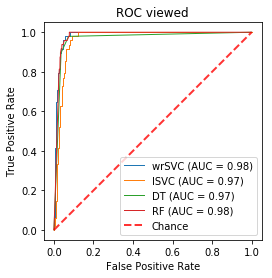

In [32]:
plot_roc_mat(y_test,df)

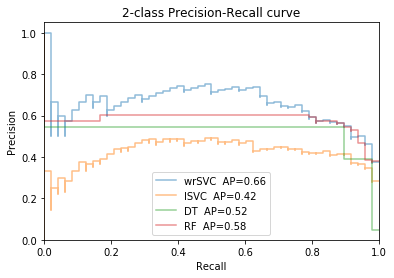

In [17]:
plot_pr_mat(y_test,df)

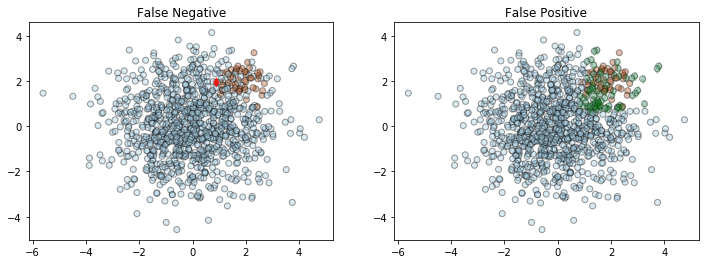

In [18]:
n=2

plt.figure(figsize=(12,4))
plt.subplot(121)

y_pred=df.loc[n,'y_pred']
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired, edgecolors='k',alpha=0.4);
ii_fn=np.nonzero((y_test==1 ) & (y_pred==0) )[0]
plt.scatter(X_test[ii_fn, 0], X_test[ii_fn, 1], c='r',marker='d',   edgecolors='r',alpha=0.8);
plt.title('False Negative')

plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired, edgecolors='k',alpha=0.4);
ii_fp=np.nonzero((y_test==0 ) & (y_pred==1) )[0]
plt.scatter(X_test[ii_fp, 0], X_test[ii_fp, 1], c='darkgreen',marker='d',   edgecolors='darkgreen',alpha=0.2);
plt.title('False Positive');



# without correction for unbalanced classes

In [19]:
wclf = svm.SVC(C=1,kernel='rbf' ,random_state=0, gamma="scale")
scoring='roc_auc'


param_dist = {
             # "class_weight": {1, uniform(1,20)} ,
              "C": uniform(0.01,100),
            }

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(wclf, scoring=scoring, param_distributions=param_dist,  cv=5, iid=False)

random_search.fit(X_train, y_train)

sorted(random_search.cv_results_.keys())
display(random_search.cv_results_['mean_test_score'])
wclf=random_search.best_estimator_

y_score = wclf.decision_function(X_test)
y_pred = wclf.predict(X_test)


bdf=add_metrics(y_test,y_score,y_pred,'wrSVC',df=None)


array([0.96998716, 0.9750751 , 0.97467104, 0.97105989, 0.97235386,
       0.97275386, 0.97556094, 0.97275386, 0.97516903, 0.97535943])

In [20]:
bdf.iloc[:,0:-2]

,model,tn,fp,fn,tp,AP
0,wrSVC,985,17,18,30,0.65227


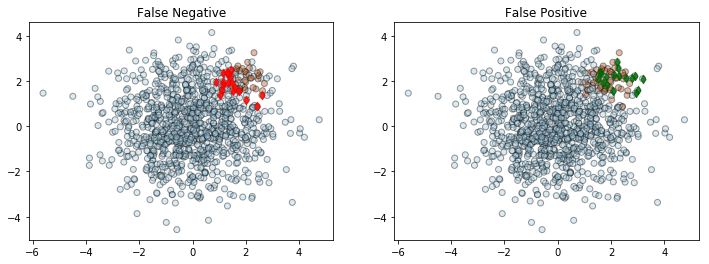

In [21]:
n=0

plt.figure(figsize=(12,4))
plt.subplot(121)

y_pred=bdf.loc[n,'y_pred']
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired, edgecolors='k',alpha=0.4);
ii_fn=np.nonzero((y_test==1 ) & (y_pred==0) )[0]
plt.scatter(X_test[ii_fn, 0], X_test[ii_fn, 1], c='r',marker='d',   edgecolors='r',alpha=0.8);
plt.title('False Negative')

plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired, edgecolors='k',alpha=0.4);
ii_fp=np.nonzero((y_test==0 ) & (y_pred==1) )[0]
plt.scatter(X_test[ii_fp, 0], X_test[ii_fp, 1], c='darkgreen',marker='d',   edgecolors='darkgreen',alpha=0.8);
plt.title('False Positive');


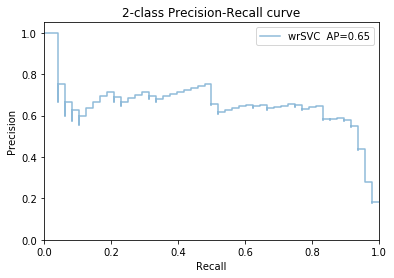

In [22]:
plot_pr_mat(y_test,bdf)
# plt.suptitle('higher precision but lower recall');

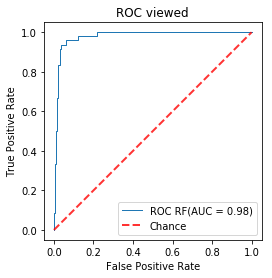

In [30]:

# probas_ = bdf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test,  y_score)

roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=1, label='ROC RF(AUC = %0.2f)' % (roc_auc));
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC viewed')
plt.legend(loc="lower right");
plt.axis('square');

In [0]:
def plot_separation(X,y,clf):
  # plot the samples
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')

  # plot the decision functions for both classifiers
  ax = plt.gca()
  xlim = ax.get_xlim()
  ylim = ax.get_ylim()

  # create grid to evaluate model
  xx = np.linspace(xlim[0], xlim[1], 30)
  yy = np.linspace(ylim[0], ylim[1], 30)
  YY, XX = np.meshgrid(yy, xx)
  xy = np.vstack([XX.ravel(), YY.ravel()]).T

  # get the separating hyperplane
  Z = clf.decision_function(xy).reshape(XX.shape)

  # plot decision boundary and margins
  a = ax.contour(XX, YY, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])


#   plt.legend([a.collections[0], b.collections[0]], ["non weighted", "weighted"],
#            loc="upper right")
  plt.show()

NameError: ignored

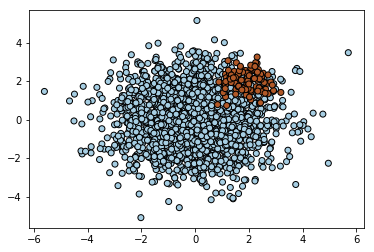

In [24]:

# plot the samples
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')

# plot the decision functions for both classifiers
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

# get the separating hyperplane
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
a = ax.contour(XX, YY, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])

# get the separating hyperplane for weighted classes
Z = wclf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins for weighted classes
b = ax.contour(XX, YY, Z, colors='r', levels=[0], alpha=0.5, linestyles=['-'])

plt.legend([a.collections[0], b.collections[0]], ["non weighted", "weighted"],
           loc="upper right")
plt.show()

In [0]:


classifier=tclf

In [0]:
# y_score = classifier.decision_function(X_test)

average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp =cm.ravel()
print(cm)

In [0]:
# wclf.decision_function(X_test)
# tclf.predict_log_proba(X_test)[:,0]

In [0]:
def plot_pr(y_test,y_score,clfs):
  
  for name   in clfs:
  
    average_precision = average_precision_score(y_test, y_score)
    precision, recall, _ = precision_recall_curve(y_test, y_score)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision,  alpha=0.5,
             where='post', label ='{0:}  AP={1:0.2f}'.format(name,average_precision))
    # plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve')
    plt.legend()

In [0]:
plot_pr(X_test,y_test,{'svc':clf,'wscv':wclf})

In [0]:
plot_separation(X_test,y_test,clf)

In [0]:
plot_separation(X_test,y_test,wclf)

In [0]:
y_score = classifier.decision_function(X_test)

precision, recall, _ = precision_recall_curve(y_test, 1+0*y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
# plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))